In [1]:
!pip install torch torchvision numpy matplotlib pillow

Episode 100/3000 | Avg Reward: -89.13 | Epsilon: 0.951
Episode 200/3000 | Avg Reward: -38.18 | Epsilon: 0.905
Episode 300/3000 | Avg Reward: -29.48 | Epsilon: 0.861
Episode 400/3000 | Avg Reward: -25.97 | Epsilon: 0.819
Episode 500/3000 | Avg Reward: -14.50 | Epsilon: 0.779
Episode 600/3000 | Avg Reward: -12.15 | Epsilon: 0.741
Episode 700/3000 | Avg Reward: -22.59 | Epsilon: 0.705
Episode 800/3000 | Avg Reward: 2.29 | Epsilon: 0.670
Episode 900/3000 | Avg Reward: -10.64 | Epsilon: 0.638
Episode 1000/3000 | Avg Reward: 3.15 | Epsilon: 0.606
Episode 1100/3000 | Avg Reward: -15.28 | Epsilon: 0.577
Episode 1200/3000 | Avg Reward: 7.13 | Epsilon: 0.549
Episode 1300/3000 | Avg Reward: 17.69 | Epsilon: 0.522
Episode 1400/3000 | Avg Reward: 23.05 | Epsilon: 0.496
Episode 1500/3000 | Avg Reward: 33.79 | Epsilon: 0.472
Episode 1600/3000 | Avg Reward: 47.62 | Epsilon: 0.449
Episode 1700/3000 | Avg Reward: 49.85 | Epsilon: 0.427
Episode 1800/3000 | Avg Reward: 51.85 | Epsilon: 0.406
Episode 1900/

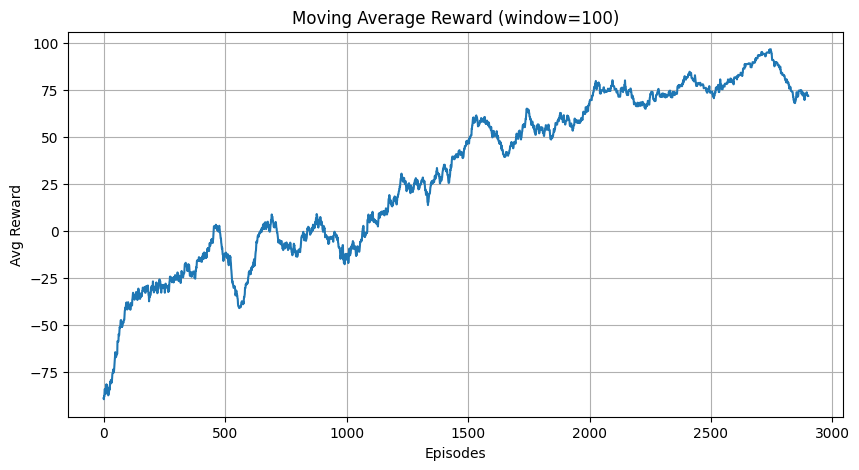

In [3]:
import os
import random
from collections import deque, namedtuple
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import pandas as pd

Transition = namedtuple('Transition', ('state', 'action', 'reward', 'next_state', 'done'))
ACTION_SPACE = 5

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

# Grid Environment
class GridEnv:
    def __init__(self, size=10, obstacle_prob=0.1, obs_window=7, max_steps=100, seed=None):
        assert obs_window % 2 == 1, "obs_window must be odd!"
        self.size = size
        self.obstacle_prob = obstacle_prob
        self.obs_window = obs_window
        self.max_steps = max_steps
        self.step_count = 0
        self.grid = None
        self.start = None
        self.goal = None
        self.agent_pos = None
        if seed is not None:
            set_seed(seed)

    def _generate_grid(self):
        g = np.zeros((self.size, self.size), dtype=np.uint8)
        mask = np.random.rand(self.size, self.size) < self.obstacle_prob
        g[mask] = 1
        return g

    def _sample_free_cell(self, grid):
        free = np.argwhere(grid == 0)
        idx = np.random.choice(len(free))
        return tuple(free[idx])

    def reset(self):
        self.step_count = 0
        self.grid = self._generate_grid()
        self.start = self._sample_free_cell(self.grid)
        self.goal = self._sample_free_cell(self.grid)
        self.grid[self.start] = 0
        self.grid[self.goal] = 0
        self.agent_pos = self.start
        return self._get_obs()

    def _get_local_window(self, pos):
        half = self.obs_window // 2
        r, c = pos
        padded = np.pad(self.grid, pad_width=half, mode='constant', constant_values=1)
        r_p, c_p = r + half, c + half
        window = padded[r_p-half:r_p+half+1, c_p-half:c_p+half+1]
        return window.astype(np.float32)

    def _get_obs(self):
        local = self._get_local_window(self.agent_pos)
        dx = (self.goal[0] - self.agent_pos[0]) / max(1, self.size - 1)
        dy = (self.goal[1] - self.agent_pos[1]) / max(1, self.size - 1)
        return np.concatenate([local.flatten(), [dx, dy]]).astype(np.float32)

    def step(self, action):
        self.step_count += 1
        r, c = self.agent_pos
        if action == 0: nr, nc = r - 1, c
        elif action == 1: nr, nc = r + 1, c
        elif action == 2: nr, nc = r, c - 1
        elif action == 3: nr, nc = r, c + 1
        else: nr, nc = r, c

        reward = -0.1
        if not (0 <= nr < self.size and 0 <= nc < self.size):
            reward += -5
        elif self.grid[nr, nc] == 1:
            reward += -10
        else:
            self.agent_pos = (nr, nc)

        done = False
        if self.agent_pos == self.goal:
            reward += 100
            done = True
        elif self.step_count >= self.max_steps:
            done = True

        return self._get_obs(), reward, done, {}

# DQN Network
class QNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, output_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

# Replay Buffer
class ReplayBuffer:
    def __init__(self, capacity=50000):
        self.buffer = deque(maxlen=capacity)

    def push(self, *args):
        self.buffer.append(Transition(*args))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        return Transition(*zip(*batch))

    def __len__(self):
        return len(self.buffer)

# DQN Agent
class DQNAgent:
    def __init__(self, state_dim, action_dim, lr=1e-3, gamma=0.99, buffer_capacity=50000, batch_size=64, target_update=1000):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.q_net = QNetwork(state_dim, action_dim).to(self.device)
        self.target_net = QNetwork(state_dim, action_dim).to(self.device)
        self.target_net.load_state_dict(self.q_net.state_dict())
        self.optimizer = optim.Adam(self.q_net.parameters(), lr=lr)
        self.gamma = gamma
        self.replay = ReplayBuffer(buffer_capacity)
        self.batch_size = batch_size
        self.learn_step = 0
        self.target_update = target_update

    def select_action(self, state, epsilon=0.1):
        if random.random() < epsilon:
            return random.randrange(ACTION_SPACE)
        state_t = torch.tensor(state, dtype=torch.float32, device=self.device).unsqueeze(0)
        with torch.no_grad():
            return int(torch.argmax(self.q_net(state_t)).item())

    def push(self, *args):
        self.replay.push(*args)

    def update(self):
        if len(self.replay) < self.batch_size:
            return
        batch = self.replay.sample(self.batch_size)
        state = torch.tensor(np.vstack(batch.state), dtype=torch.float32, device=self.device)
        action = torch.tensor(batch.action, dtype=torch.int64, device=self.device).unsqueeze(1)
        reward = torch.tensor(batch.reward, dtype=torch.float32, device=self.device).unsqueeze(1)
        next_state = torch.tensor(np.vstack(batch.next_state), dtype=torch.float32, device=self.device)
        done = torch.tensor(batch.done, dtype=torch.float32, device=self.device).unsqueeze(1)

        q_values = self.q_net(state).gather(1, action)
        with torch.no_grad():
            q_next = self.target_net(next_state).max(1)[0].unsqueeze(1)
            q_target = reward + (1 - done) * self.gamma * q_next

        loss = F.smooth_l1_loss(q_values, q_target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.learn_step += 1
        if self.learn_step % self.target_update == 0:
            self.target_net.load_state_dict(self.q_net.state_dict())

# Training
def train_and_save_model():
    GRID_SIZE = 10
    OBS_WINDOW = 7
    MAX_STEPS = 100
    EPISODES = 3000
    EPSILON_START = 1.0
    EPSILON_MIN = 0.05
    EPSILON_DECAY = 0.9995

    env = GridEnv(size=GRID_SIZE, obstacle_prob=0.1, obs_window=OBS_WINDOW, max_steps=MAX_STEPS, seed=42)
    state_dim = env.obs_window * env.obs_window + 2
    agent = DQNAgent(state_dim, ACTION_SPACE, lr=1e-3)

    epsilon = EPSILON_START
    rewards_log = []

    for ep in range(1, EPISODES + 1):
        state = env.reset()
        done = False
        total_reward = 0

        while not done:
            r_old, c_old = env.agent_pos
            old_dist = abs(r_old - env.goal[0]) + abs(c_old - env.goal[1])

            action = agent.select_action(state, epsilon)
            next_state, reward, done, _ = env.step(action)

            r_new, c_new = env.agent_pos
            new_dist = abs(r_new - env.goal[0]) + abs(c_new - env.goal[1])

            # Reward shaping
            if new_dist < old_dist:
                reward += 1.0
            elif new_dist > old_dist:
                reward -= 0.5
            if done and env.agent_pos != env.goal:
                reward -= 20

            agent.push(state, action, reward, next_state, done)
            agent.update()

            state = next_state
            total_reward += reward

        epsilon = max(EPSILON_MIN, epsilon * EPSILON_DECAY)
        rewards_log.append(total_reward)

        if ep % 100 == 0:
            print(f"Episode {ep}/{EPISODES} | Avg Reward: {np.mean(rewards_log[-100:]):.2f} | Epsilon: {epsilon:.3f}")

    # Save model
    os.makedirs('./models', exist_ok=True)
    model_path = './models/dqn_navigation.pth'
    torch.save(agent.q_net.state_dict(), model_path)
    print(f"Model saved at {model_path}")

    # Save rewards
    os.makedirs('./data', exist_ok=True)
    rewards_path = './data/training_rewards.csv'
    pd.DataFrame({"reward": rewards_log}).to_csv(rewards_path, index=False)
    print(f"Rewards saved at {rewards_path}")

    return agent, env, rewards_log

# Evaluation
def evaluate_model(agent, env, episodes=100):
    agent.q_net.eval()
    successes = 0
    for _ in range(episodes):
        state = env.reset()
        done = False
        while not done:
            action = agent.select_action(state, epsilon=0.0)
            state, _, done, _ = env.step(action)
        if env.agent_pos == env.goal:
            successes += 1
    print(f"Success rate: {successes}/{episodes} = {successes/episodes:.2f}")

# Plotting function
def plot_training_progress(rewards_log):
    plt.figure(figsize=(10,5))
    plt.plot(np.convolve(rewards_log, np.ones(100)/100, mode='valid'))
    plt.title("Moving Average Reward (window=100)")
    plt.xlabel("Episodes")
    plt.ylabel("Avg Reward")
    plt.grid()
    plt.show()

# Main
if __name__ == "__main__":
    agent, env, rewards_log = train_and_save_model()
    evaluate_model(agent, env)
    plot_training_progress(rewards_log)
